# 1 Load Packages

In [ ]:
conda install -c conda-forge wordcloud

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Surpress Scientific Notation
pd.options.display.float_format = '{:.2f}'.format

# 2 Load Data

In [ ]:
# First two rows of csv describe the column
data = pd.read_csv("Data Breaches - Raw Data.csv",header=[0,1])

In [ ]:
# Check rows, columns
dim = data.shape
(rowCount,colCount) = dim

# Return shape
txt = "Rows: {rows}, Columns: {cols}"
print(txt.format(rows=rowCount,cols=colCount))

Rows: 339, Columns: 14


# 3 Data Description

In [ ]:
# Remove Extra Symbols
data.rename(columns=lambda x: re.sub('\n', '; ', x.strip()),inplace=True)

In [ ]:
# Column Headers and Data Types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 14 columns):
 #   Column                                                                                                                                                                  Non-Null Count  Dtype  
---  ------                                                                                                                                                                  --------------  -----  
 0   (Entity, Unnamed: 0_level_1)                                                                                                                                            339 non-null    object 
 1   (alternative name, Unnamed: 1_level_1)                                                                                                                                  136 non-null    object 
 2   (records lost, Unnamed: 2_level_1)                                                                    

In [ ]:
# Example Row
data.head(1)

,Entity,alternative name,records lost,YEAR,story,SECTOR,METHOD,interesting story,DATA SENSITIVITY,DISPLAYED RECORDS,Unnamed: 10_level_0,source name,1st source link,2nd source link
,Unnamed: 0_level_1,Unnamed: 1_level_1,Unnamed: 2_level_1,year story broke,Unnamed: 4_level_1,web; healthcare; app; retail; gaming; transport; financial; tech; government; telecoms; legal; media; academic; energy; military,poor security; hacked; oops!; lost device ; inside job,Unnamed: 7_level_1,1. Just email address/Online information ; 2 SSN/Personal details ; 3 Credit card information ; 4 Health & other personal records ; 5 Full details,"=IF(C3>100000000,C3,"")",Unnamed: 10_level_1,Unnamed: 11_level_1,Unnamed: 12_level_1,Unnamed: 13_level_1
0,US Customs and Border Protection,NaN,"100,000",2019,June 2019. Photos of travellers' faces and lic...,government,hacked,y,2,NaN,NaN,Washington Post,https://www.washingtonpost.com/technology/2019...,NaN


# 4 Data Cleaning and Validation

## Cleaning Columns

In [ ]:
# Remove Empty Column

## Get index of null columns
nulls = data.isna().sum()
nullsIx = [ix for ix,i in enumerate(nulls.index) if (nulls[i] == rowCount)]

## Remove null columns by index
data.drop(data.columns[nullsIx],axis=1,inplace=True)

In [ ]:
# Clean Headers

## Fix Empty Headers
data.rename(columns=lambda x: re.sub('Unnamed.*_1', '', x.strip()),inplace=True)

## Fix Capitalization
data.rename(columns=lambda x: x.title(),inplace=True)

In [ ]:
# Check Headers
data.head(0)

,Entity,Alternative Name,Records Lost,Year,Story,Sector,Method,Interesting Story,Data Sensitivity,Displayed Records,Source Name,1St Source Link,2Nd Source Link
,,,,Year Story Broke,,Web; Healthcare; App; Retail; Gaming; Transport; Financial; Tech; Government; Telecoms; Legal; Media; Academic; Energy; Military,Poor Security; Hacked; Oops!; Lost Device ; Inside Job,,1. Just Email Address/Online Information ; 2 Ssn/Personal Details ; 3 Credit Card Information ; 4 Health & Other Personal Records ; 5 Full Details,"=If(C3>100000000,C3,"")",,,


## Cleaning Rows

In [ ]:
# Convert Records Lost to Numeric

## Remove Commas
data['Records Lost'] = data['Records Lost'].replace(',','',regex=True)

## Story seems to have data quality issue when reporting ALL records 
data['Records Lost'] = data['Records Lost'].replace('ALL','',regex=True)

# M stands for 1,000,000
data['Records Lost'] = data['Records Lost'].replace('M','000000',regex=True)

# An upper bound is an appropriate estimate
data['Records Lost'] = data['Records Lost'].replace('<','',regex=True)

# Run the conversion
data['Records Lost'] = pd.to_numeric(data['Records Lost'], errors='coerce')

# Check stats: record losses vary from 1 thousand to 137 billion
data['Records Lost'].describe()

count          335.00
mean      40444500.33
std      144980789.89
min           1025.00
25%         475000.00
50%        3000000.00
75%       18000000.00
max     1370000000.00
Name: Records Lost, dtype: float64

In [ ]:
# Fix Sources

## Guardian
data['Source Name'] = data['Source Name'].replace('The Guardian','Guardian',regex=True)

## NYTimes
data['Source Name'] = data['Source Name'].replace('NYTimes','NY Times',regex=True)

# 5 Data Mining

In [ ]:
# Clean Breach Size
loss = data['Records Lost']
lossCleaned = loss.dropna()

In [ ]:
# Investigate Source
sources = data['Source Name']

# We see that there 
sources.describe()

count          339
unique         163
top       Guardian
freq            24
Name: Source Name, dtype: object

In [ ]:
# Get Top Sources
sourceCounts = sources.value_counts().to_dict()

In [ ]:
# Get Top Search Terms in Story

## Make Corpus
corpus = data['Story']

## Make Vectorizer in single English words
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1,1))

## Apply Vectorizer
X = vectorizer.fit_transform(corpus)

## Get Search Terms
feature_names = vectorizer.get_feature_names_out()

## Convert Matrix to Dataframe
dense = X.todense()
denselist = dense.tolist()
searchTerms = pd.DataFrame(denselist, columns=feature_names)

# Clean Dataframe
searchTerms.rename(columns=lambda x: re.sub('äú', '', x.strip()),inplace=True)
searchTerms.head(1)

,000,05,072,10,100,1000,100m,1025,106,10gb,...,äôs,äù,a,clandestinely,clicking,compromised,data,downloads,sony,unauthorized
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# Get Breaches Over Time

## Multi-index Columns
recordCol = ('Records Lost','')
yearCol = ('Year','Year Story Broke')
dataTime = data.loc[:, [yearCol,recordCol]]
dataTime[yearCol] = dataTime[yearCol].astype(int)

## Get total records lost per year
breachTime = dataTime.groupby([yearCol]).sum()

## Check stats: annual losses vary from 1.8 million to 1.5 billion
breachTime.describe()

,Records Lost
,
count,17.00
mean,796994565.29
std,1145098086.44
min,1800000.00
25%,88455500.00
50%,232898177.00
75%,1558750000.00
max,4071586578.00


In [ ]:
# Get average records lost per year
breachAvg = dataTime.groupby([yearCol]).mean()

# Check stats: average losses per breach vary from 703 thousand to 98.2 million
breachAvg.describe()

,Records Lost
,
count,17.00
mean,33248176.13
std,33702157.81
min,703285.67
25%,10126007.70
50%,17824968.21
75%,51958333.33
max,98207652.36


In [ ]:
# Get counts by sector
sectorData = data.iloc[:,5]
sectorCounts = sectorData.value_counts()

# Check stats: Largest sector had 97 breaches and smallest sector had 1 breach
sectorCounts.describe()

count   24.00
mean    14.12
std     21.87
min      1.00
25%      1.00
50%      4.00
75%     17.00
max     97.00
Name: (Sector, Web; Healthcare; App; Retail; Gaming; Transport; Financial; Tech; Government; Telecoms; Legal; Media; Academic; Energy; Military), dtype: float64

In [ ]:
# Get counts by method
methodData = data.iloc[:,6]
methodCounts = methodData.value_counts()

# Check stats: Most common method was used 214 times and least common method was used 19 times
methodCounts.describe()

count     5.00
mean     67.80
std      82.62
min      19.00
25%      20.00
50%      39.00
75%      47.00
max     214.00
Name: (Method, Poor Security; Hacked; Oops!; Lost Device ; Inside Job), dtype: float64

# 6 Data Visualization

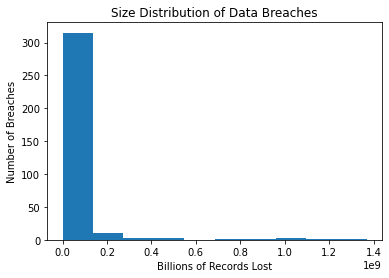

In [ ]:
# Visualize Breach Size

## Set Plot Parameters
fig1, ax1 = plt.subplots()
ax1.set_title("Size Distribution of Data Breaches")
ax1.set_ylabel("Number of Breaches")
ax1.set_xlabel("Billions of Records Lost")

## Make Plot
plt.hist(lossCleaned) 
plt.show()
fig1.savefig("breach.jpg",bbox_inches = "tight")

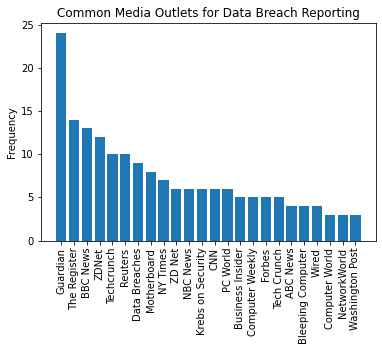

In [ ]:
# Visualize Top Sources

## Filter to 3 or more occurrences
sourceCountsFiltered = { key:value for (key,value) in sourceCounts.items() if (value >= 3)}

## Set Plot Parameters
fig2, ax2 = plt.subplots()
ax2.set_title("Common Media Outlets for Data Breach Reporting")
plt.xticks(rotation=90)
ax2.set_ylabel("Frequency")

## Make Plot
plt.bar(range(len(sourceCountsFiltered)), list(sourceCountsFiltered.values()), align='center')
plt.xticks(range(len(sourceCountsFiltered)), list(sourceCountsFiltered.keys()))
plt.show()
fig2.savefig("source.jpg",bbox_inches = "tight")

In [ ]:
# Word Cloud Helper Function

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    """
    Change the value of words in word cloud to black
    """
    return("hsl(0,100%, 1%)")

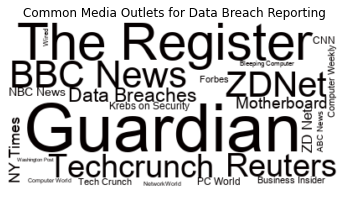

In [ ]:
# Alternative Top Sources Visualization

## Make Word Cloud
wordcloud = WordCloud(font_path='/Library/Fonts/Arial Unicode.ttf',background_color="white").generate_from_frequencies(sourceCountsFiltered)

## Format Word Cloud
fig3, ax3 = plt.subplots()
ax3.set_title("Common Media Outlets for Data Breach Reporting")
plt.axis("off")
wordcloud.recolor(color_func = black_color_func)

## Show Word Cloud
plt.imshow(wordcloud, interpolation="bilinear")
fig3.savefig("searchTerm.jpg",bbox_inches = "tight")

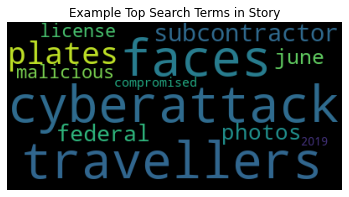

In [ ]:
# Top Search Terms Visualization in a Document

## Prep Dataframe
searchTermsIn = searchTerms.transpose()
searchTermsIn.columns = data['Story']

## Example Story
story1 = data['Story'][0]

## Format Word Cloud
plt.title("Example Top Search Terms in Story")
plt.axis("off")

## Create Word Cloud
wordcloud2 = WordCloud().generate_from_frequencies(searchTermsIn[story1])
plt.imshow(wordcloud2)

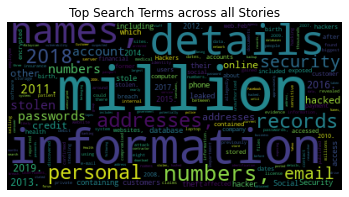

In [ ]:
# Top Search Terms Visualization for a Corpus

## Make String
allStory = data['Story'].str.cat(sep='')

## Get Frequencies
allWords = allStory.split()
allWordsFreq = [allWords.count(w) for w in allWords]
allWordsDict = dict(zip(allWords,allWordsFreq))

## Format Word Cloud
plt.title("Top Search Terms across all Stories")
plt.axis("off")

## Filter to 5 or more characters
allWordsDictFiltered = { key:value for (key,value) in allWordsDict.items() if (len(key) >= 5)}

## Create Word Cloud
wordcloud3 = WordCloud().generate_from_frequencies(allWordsDictFiltered)
plt.imshow(wordcloud3)

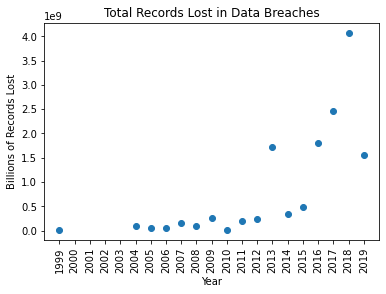

Total records lost are increasing about 147678146 records year-over-year


In [ ]:
# Total Records Lost Over Time

## Label Plot
fig4, ax4 = plt.subplots()
ax4.set_title("Total Records Lost in Data Breaches")
ax4.set_ylabel("Billions of Records Lost")
ax4.set_xlabel("Year")

## Format Plot
plt.xticks(range(1999,2020))
plt.xticks(rotation=90)

## Make Regression
x,y = list(breachTime.index), list(breachTime.iloc[:,0])
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 

## Make Plot
plt.plot(breachTime,marker='o',ls='')
plt.show()
fig4.savefig("total.jpg",bbox_inches = "tight")

txt = "Total records lost are increasing about {slope} records year-over-year"
print(txt.format(slope=int(coef[0])))

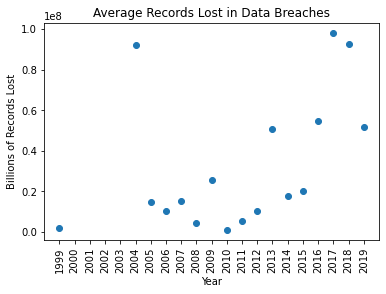

Average records lost are increasing about 2821207 records year-over-year


In [ ]:
# Average Records Lost Over Time

## Label Plot
plt.title("Average Records Lost in Data Breaches")
plt.ylabel("Billions of Records Lost")
plt.xlabel("Year")

## Format Plot
plt.xticks(range(1999,2020))
plt.xticks(rotation=90)

## Make Regression
x,y = list(breachAvg.index), list(breachAvg.iloc[:,0])
coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 

## Make Plot
plt.plot(breachAvg,marker='o',ls='')
plt.show()

txt = "Average records lost are increasing about {slope} records year-over-year"
print(txt.format(slope=int(coef[0])))

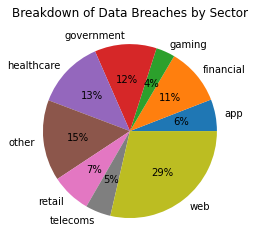

Other sectors: ['academic', 'transport', 'tech', 'media', 'tech, web', 'military', 'energy', 'tech, retail', 'government, healthcare', 'web, gaming', 'military, healthcare', 'legal', 'web, military', 'web, tech', 'tech, app', 'government, military']


In [ ]:
# Visualize Sector

## Aggregate Small Values
sectorDict = sectorCounts.to_dict()
sectorDictFiltered = {key:'other' for (key,value) in sectorDict.items() if (value <= 10)}
otherSectors = sectorDictFiltered.keys()
sectorCounts.rename(index=sectorDictFiltered,inplace=True)
sectorCounts = sectorCounts.groupby(level=0).sum()

## Make Pie
fig5, ax5 = plt.subplots()
ax5.set_title("Breakdown of Data Breaches by Sector")
plt.pie(sectorCounts,labels=sectorCounts.index,autopct='%1.0f%%')

## Show Pie
plt.show()
fig5.savefig("sectors.jpg",bbox_inches = "tight")

print("Other sectors:",list(otherSectors))

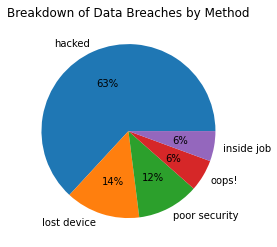

In [ ]:
# Visualize Method

## Make Pie
fig6, ax6 = plt.subplots()
ax6.set_title("Breakdown of Data Breaches by Method")
plt.pie(methodCounts,labels=methodCounts.index,autopct='%1.0f%%')

## Show Pie
plt.show()
fig6.savefig("methods.jpg",bbox_inches = "tight")

In [ ]:
sectorDict = sectorCounts.to_dict()
sectorDictFiltered = {key:'other' for (key,value) in sectorDict.items() if (value <= 10)}

# 7 Presenting Conclusions

#### The typical record loss is about 3 million records, although this can vary between a thousand records and 1.37 billion. 

![image info](Images/breach.jpg)

Note that record losses of less than 500 are not reportable to the media, and also less likely to be captured from web-crawling, so there is under-representation of the impact of smaller record losses.

#### Media coverage of data breaches occur most often on mainstream news sites such as Guardian, The Register, and BBC News.

![image info](Images/source.jpg)

Note that the dataset shows an overall bias towards English-language news media, with a slight bias towards British-English news media. Further work should look into more representation from other parts of the English-speaking world, as well as non-English speaking media such as Spanish, Russian, and so on.

#### The most common search terms in media stories involving data breaches include names, numbers, and addresses.

![image info](Images/searchTerm.jpg)

Also common are boilerplate words such as million, information, details, which we may want to remove from the natural language processing.

#### Both the total number of records lost and the average number of records lost per breach are increasing year-over-year. Total number of records lost are increasing about 147 million records year-over-year. Average number of records lost per data breach are increasing about 282 thousand records year-over-year.

![image info](Images/total.jpg)

However, we should be careful about the recency effect. More recent breaches may be better documented, which can increase the reported number of records lost in recent years. Furthermore, the number of breach stories in the dataset is a few hundred, and further study with a larger number of breach stories on the order of a few thousand is needed to better illuminate this trend.

#### The most common sectors to experience data breaches are internet, healthcare, government, and financial institutions.

![image info](Images/sectors.jpg)

Some of the less common sectors for data breaches include energy, gaming, and academic institutions. Furthermore, if a sector did not report any breaches then it would not be included in the analysis.

#### The most common hacking methods were lost devices and insider threats, although the vast majority of hacking methods are unknown.

![image info](Images/methods.jpg)

For institutions that had poor security or were hacked, additional information is needed to specify the hacking method employed in the attack.

### End of Notebook